# Objetivo

Desenvolver um modelo de machine learning para realizar an√°lise de sentimentos em reviews de aplicativos. O projeto utilizar√° t√©cnicas de processamento de linguagem natural (NLP) para identificar e classificar as emo√ß√µes expressas nos textos. O objetivo √© criar uma ferramenta que melhore a compreens√£o do feedback dos usu√°rios e outros conte√∫dos textuais, fornecendo insights valiosos de forma automatizada.

### Configura√ß√£o do ambiente

In [1]:
!pip install datasets huggingface_hub torch matplotlib scikit-learn
!pip install transformers --upgrade
!pip install accelerate>0.21.0
#!pip install nltk
!pip install spacy # usando spacy tendo envista que nltk n√£o est√° funcionando (LookupError)

import os

# Desativa o paralelismo para evitar deadlocks
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# configura√ß√£o para n√£o exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necess√°rios
import pandas as pd
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#import nltk
#nltk_data_path = os.path.abspath('./nltk_data')
#nltk.data.path.append(nltk_data_path)
#nltk.download('stopwords', download_dir=nltk_data_path, force=True)
#nltk.download('punkt', download_dir=nltk_data_path, force=True)
#from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

import spacy
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

import datasets
from datasets import Dataset, DatasetDict, load_metric


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Dataset

O dataset cont√©m avalia√ß√µes e notas dos 10 aplicativos mais populares na categoria de comida e bebidas, dispon√≠veis na Google Play Store do Brasil. As notas variam de 1 a 5, e a ideia √© fazer a seguinte classifica√ß√£o:

* 1 e 2: Avalia√ß√µes Negativas
* 4 e 5: Avalia√ß√µes Positivas
* As avalia√ß√µes neutras (3) ser√£o descartadas para simplifica√ß√£o do problema.

### Descri√ß√£o das colunas:

* reviewId: ID da avalia√ß√£o
* userName: Nome de usu√°rio
* userImage: Avatar do usu√°rio
* content: Texto da avalia√ß√£o
* score: Nota atribu√≠da na avalia√ß√£o
* thumbsUpCount: N√∫mero de curtidas
* reviewCreatedVersion: Vers√£o do aplicativo no momento da avalia√ß√£o
* at: Data da avalia√ß√£o
* replyContent: Texto da resposta √† avalia√ß√£o
* repliedAt: Data da resposta √† avalia√ß√£o
* appVersion: Vers√£o do aplicativo
* sortOrder: Ordem de classifica√ß√£o
* appId: ID do aplicativo





### Carregando o dataset

In [2]:
# Informa a URL de importa√ß√£o do dataset
#url = "https://raw.githubusercontent.com/bpbastos/sentiment-analysis-ml-api/main/android_app_reviews.csv?token=GHSAT0AAAAAACSFFAPRMUHD2ZIBMDIWUJSWZWRHYEQ"
url = "../data/android_app_reviews.csv"

# L√™ o arquivo
dataset = pd.read_csv(url, delimiter=',', encoding='utf-8')

# Diminiu o dataset para 1000 inst√¢ncias
#n_samples_per_class = 500
#n_samples_score_3 = n_samples_per_class * 2

# Amostra 500 inst√¢ncias de cada classe, exceto para o score 3, onde amostra 1000 inst√¢ncias
#dataset_others = dataset[dataset['score'] != 3].groupby('score').sample(n=n_samples_per_class, random_state=42)
#dataset_score_3 = dataset[dataset['score'] == 3].sample(n=n_samples_score_3, random_state=42)

# Concatena os datasets
#dataset = pd.concat([dataset_others, dataset_score_3])

#Desprezando os coment√°rios com score 3 (neutro)
dataset = dataset[dataset['score'] != 3]

#
dataset.head()

reviewId             userName  \
0  9b2090fb-2acf-4ade-bff4-1bd65f714e89  Julia Lopes Ogleari   
1  fb9bccfd-573d-47cf-aafe-fbeafe53f55b           David Paul   
2  a8da45e3-66c6-44b2-8ff3-905c9c266914        Larissa Keity   
3  edeb5bbd-7d01-4c02-88b2-c65c3b82373b        Lorenna Petri   
4  1fa4b8eb-9423-4f8e-9ba7-3be0d5805f96       Jordana Araujo   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a-/ALV-U...   
1  https://play-lh.googleusercontent.com/a-/ALV-U...   
2  https://play-lh.googleusercontent.com/a-/ALV-U...   
3  https://play-lh.googleusercontent.com/a-/ALV-U...   
4  https://play-lh.googleusercontent.com/a-/ALV-U...   

                                             content  score  thumbsUpCount  \
0  S√≥ decep√ß√µes. As √∫ltimas vezes que pedi com es...      1             49   
1  Era muito bom quando a preocupa√ß√£o era atender...      1              5   
2  √â frustrante vc fazer um pedido num restaurant...      1              8   
3  O processo de cancelamento √© dificultado para ...      1            201   
4  Eu n√£o consigo mais usar o app. Instalei ele d...      1            389   

  reviewCreatedVersion                   at replyContent repliedAt appVersion  \
0              10.32.0  2024-08-27 00:32:41          NaN       NaN    10.32.0   
1              10.27.0  2024-08-28 01:25:52          NaN       NaN    10.27.0   
2              10.32.0  2024-08-28 02:55:34          NaN       NaN    10.32.0   
3              10.28.0  2024-07-30 11:40:22          NaN       NaN    10.28.0   
4              10.28.0  2024-08-03 16:26:19          NaN       NaN    10.28.0   

       sortOrder                  appId  
0  most_relevant  br.com.brainweb.ifood  
1  most_relevant  br.com.brainweb.ifood  
2  most_relevant  br.com.brainweb.ifood  
3  most_relevant  br.com.brainweb.ifood  
4  most_relevant  br.com.brainweb.ifood

In [3]:
# Informa√ß√µes gerais sobre o dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              8000 non-null   object
 1   userName              8000 non-null   object
 2   userImage             8000 non-null   object
 3   content               8000 non-null   object
 4   score                 8000 non-null   int64 
 5   thumbsUpCount         8000 non-null   int64 
 6   reviewCreatedVersion  7244 non-null   object
 7   at                    8000 non-null   object
 8   replyContent          3300 non-null   object
 9   repliedAt             3300 non-null   object
 10  appVersion            7244 non-null   object
 11  sortOrder             8000 non-null   object
 12  appId                 8000 non-null   object
dtypes: int64(2), object(11)
memory usage: 875.0+ KB


### Pr√©-processamento
Distribui√ß√£o dos reviews por nota

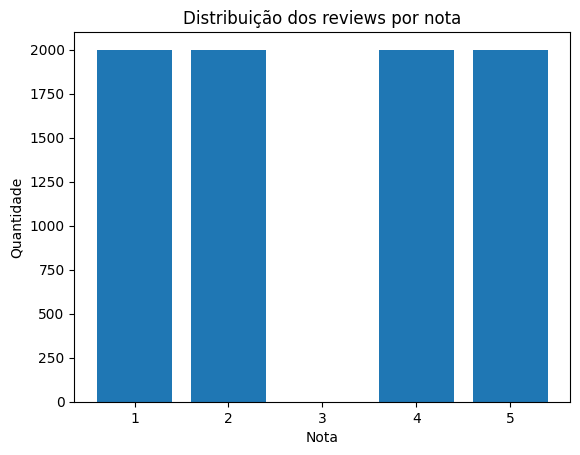

In [4]:
# Calcula a contagem de cada valor de 'score'
score_counts = dataset['score'].value_counts()

# Histograma do n√∫mero de reviews de acordo com a nota:
plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Nota')
plt.ylabel('Quantidade')
plt.title('Distribui√ß√£o dos reviews por nota')
plt.show()

Balanceamento do dataset

In [5]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating > 3:
    return 1

dataset['sentiment'] = dataset.score.apply(to_sentiment)

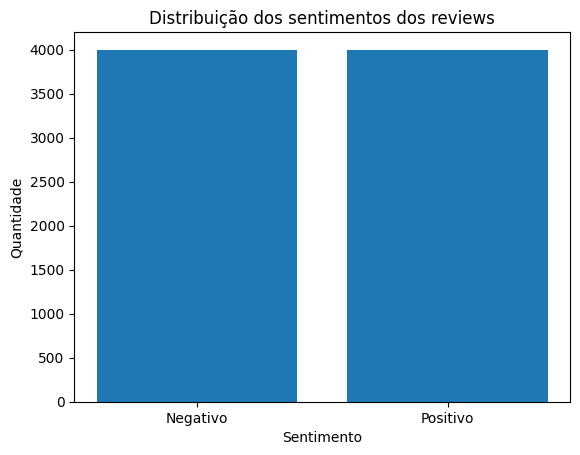

In [6]:
class_names = ['Negativo', 'Positivo']
sentiment_counts = dataset['sentiment'].value_counts()
plt.bar(class_names, sentiment_counts.values)
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.title('Distribui√ß√£o dos sentimentos dos reviews')
plt.show()


### Limpeza e Vetoriza√ß√£o do texto

Adicionando novas stop words ao dicion√°rio da biblioteca spacy

In [7]:
# Execute python -m spacy download pt_core_news_sm para download do modelo em portugu√™s

# Stop words em portugu√™s
novas_stop_words = [ 'a', '√†', 'adeus', 'agora', 'a√≠', 'ainda', 'al√©m', 'algo', 'algu√©m', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'ap√≥s', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', '√°rea', 'as', '√†s', 'assim', 'at√©', 'atr√°s', 'atrav√©s', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'c√°', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'd√°', 'd√£o', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'dever√°', 'dever√£o', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'd√∫vida', 'e', '√©', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', '√©ramos', '√©s', 'essa', 'essas', 'esse', 'esses', 'esta', 'est√°', 'estamos', 'est√£o', 'estar', 'estas', 'est√°s', 'estava', 'estavam', 'est√°vamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estiv√©ramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estiv√©ssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'fa√ßo', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'f√¥ramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'f√¥ssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'h√°', 'haja', 'hajam', 'hajamos', 'h√£o', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houver√°', 'houveram', 'houv√©ramos', 'houver√£o', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houver√≠amos', 'houvermos', 'houvesse', 'houvessem', 'houv√©ssemos', 'isso', 'isto', 'j√°', 'la', 'l√°', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'm√°ximo', 'me', 'meio', 'menor', 'menos', 'm√™s', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'n√£o', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ningu√©m', 'n√≠vel', 'no', 'noite', 'nome', 'nos', 'n√≥s', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'n√∫mero', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'p√¥de', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'p√µe', 'p√µem', 'pois', 'ponto', 'pontos', 'por', 'por√©m', 'porque', 'porqu√™', 'posi√ß√£o', 'poss√≠vel', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'pr√≥pria', 'pr√≥prias', 'pr√≥prio', 'pr√≥prios', 'pr√≥xima', 'pr√≥ximas', 'pr√≥ximo', 'pr√≥ximos', 'pude', 'puderam', 'quais', 'qu√°is', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'qu√™', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'quest√£o', 'quinta', 'quinto', 'quinze', 'rela√ß√£o', 'sabe', 'sabem', 's√£o', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'ser√°', 'ser√£o', 'serei', 'seremos', 'seria', 'seriam', 'ser√≠amos', 'sete', 's√©tima', 's√©timo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 's√≥', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'tamb√©m', 'tampouco', 'tanta', 'tantas', 'tanto', 't√£o', 'tarde', 'te', 'tem', 't√©m', 't√™m', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'ter√°', 'ter√£o', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'ter√≠amos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 't√≠nhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tiv√©ramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tiv√©ssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'tr√™s', 'treze', 'tu', 'tua', 'tuas', 'tudo', '√∫ltima', '√∫ltimas', '√∫ltimo', '√∫ltimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'v√£o', 'v√°rios', 'vem', 'v√™m', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'voc√™', 'voc√™s', 'vos', 'v√≥s', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

# Carregue o modelo em portugu√™s
nlp = spacy.load("pt_core_news_sm")

# Adiciona cada palavra da lista √†s stop words do spaCy
for word in novas_stop_words:
    nlp.Defaults.stop_words.add(word)
    # Marca como stop word no vocabul√°rio
    nlp.vocab[word].is_stop = True

Limpando, removendo stop words e lematizando o texto 

In [8]:
print('Sem processamento:', dataset['content'].iloc[0])

# Define a fun√ß√£o para remover caracteres especiais
def remove_special_characters(text):
    return ''.join(char for char in text if char not in '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

# Define a fun√ß√£o para converter todos os caracteres para min√∫sculo
def to_lowercase(text):
    return text.lower()

# Fun√ß√£o para remover stopwords
def remove_stopwords(text):
    doc = nlp(text)
    return ' '.join([token.text for token in doc if not token.is_stop])

# Fun√ß√£o para lematizar o texto
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def clean_text(text_list):
    # Converte todos os elementos para strings
    cleaned_text_list = text_list.astype(str)

    # Aplica a fun√ß√£o para remover caracteres especiais 
    cleaned_text_list = cleaned_text_list.apply(remove_special_characters)

    # Aplica a fun√ß√£o para converter todos os caracteres para min√∫sculo
    cleaned_text_list = cleaned_text_list.apply(to_lowercase)

    # Aplica a fun√ß√£o para remover stopwords
    cleaned_text_list = cleaned_text_list.apply(remove_stopwords)

    # Aplica a fun√ß√£o para lematizar o texto
    cleaned_text_list = cleaned_text_list.apply(lemmatize_text)

    return cleaned_text_list

# Converte todos os elementos na coluna 'content' para strings
cleaned_dataset = clean_text(dataset['content'])

# Imprime o texto ap√≥s o processamento
print('Com processamento:', cleaned_dataset.iloc[0])

Sem processamento: S√≥ decep√ß√µes. As √∫ltimas vezes que pedi com esse aplicativo, TODAS deram ruim com a entrega. Seja faltando itens, seja entregador que some com a comida, seja l√° o que for que d√° pra acontecer de errado, acontece. Servi√ßo est√° horrivrl e por mais que d√™em o reembolso, ainda n√£o vale a pena o stress. Desinstalando sem nenhum pesar. Recomendo a todos que fa√ßam o mesmo pois a tend√™ncia √© piorar.
Com processamento: decep√ß√£o pedir aplicativo dar ruim entregar faltar item entregador some comer pra acontecer errar acontecer servi√ßo horrivrl d√™em reembolso valer pena stress desinstalar pesar recomer fa√ßam tend√™ncia piorar


Convertendo o texto em vetor

In [9]:
# Separando entrada e sa√≠da
X = cleaned_dataset  # Texto do review limpo
y = dataset['sentiment'] # Sentimento 0(negativo)/2(negativo)

# Vetoriza√ß√£o do texto usando CountVectorizer
vectorizer = CountVectorizer(analyzer = "word")

# Ajuste e transforma√ß√£o no conjunto de treino
X = vectorizer.fit_transform(X)

## Modelagem
### Sklearn

Separa√ß√£o em conjunto de treino e conjunto de teste com holdout

In [10]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleat√≥ria

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratifica√ß√£o

# Par√¢metros e parti√ß√µes da valida√ß√£o cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # valida√ß√£o cruzada com estratifica√ß√£o

LR: 0.806719 (0.013018)
KNN: 0.668281 (0.010529)
CART: 0.763594 (0.015626)
NB-Gaussian: 0.650000 (0.014987)
NB-Multinomial: 0.775625 (0.016700)
NB-Bernoulli: 0.743437 (0.017312)
SVM: 0.802812 (0.012119)
Bagging: 0.788750 (0.011154)
RF: 0.819844 (0.014491)
ET: 0.822813 (0.014892)
Ada: 0.749844 (0.015443)
GB: 0.755156 (0.014939)
Voting: 0.816094 (0.007560)


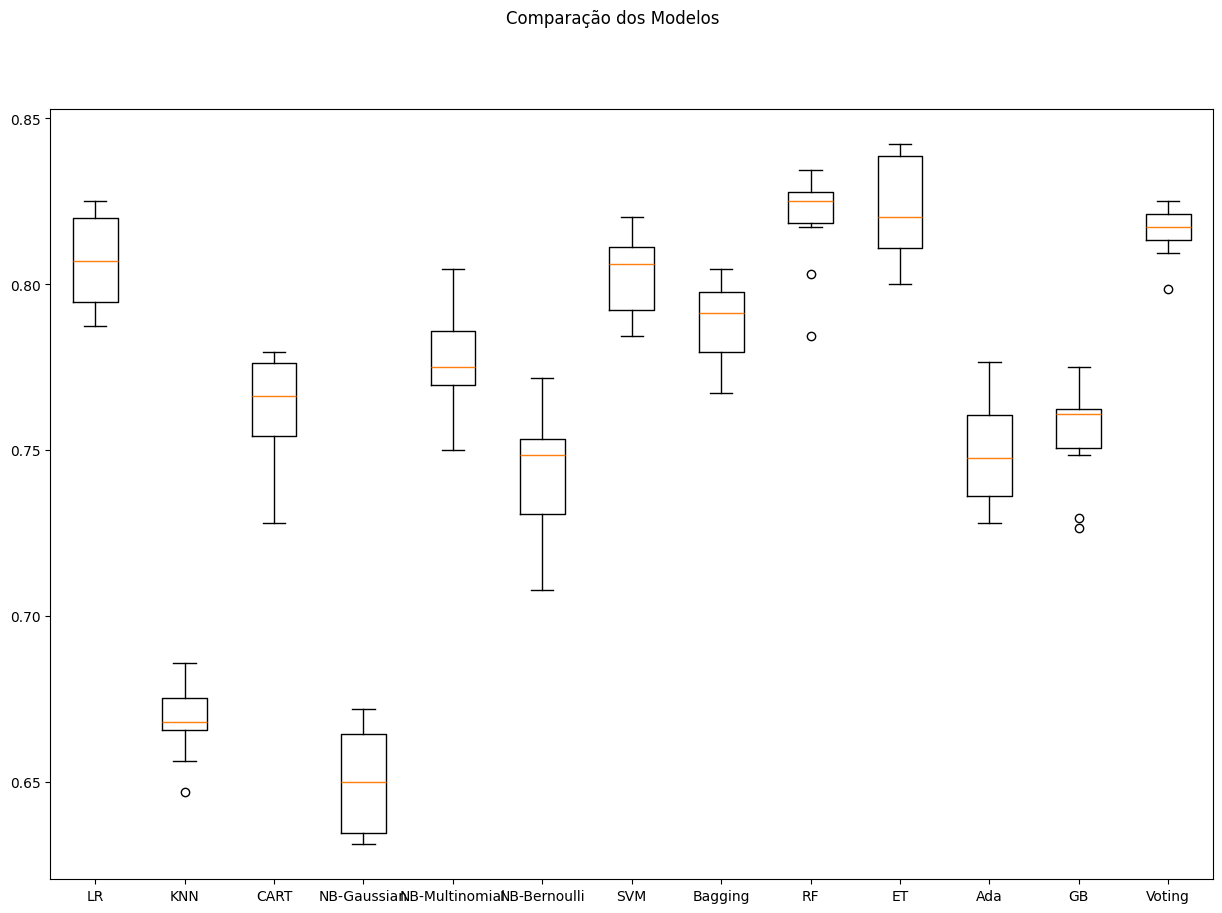

In [11]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenar√° os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB-Gaussian', GaussianNB()))
models.append(('NB-Multinomial', MultinomialNB(alpha=1.0, fit_prior=True)))
models.append(('NB-Bernoulli', BernoulliNB(alpha=1.0, fit_prior=True)))
models.append(('SVM', SVC()))

# Definindo os par√¢metros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avalia√ß√£o dos modelos
for name, model in models:
    if name == 'NB-Gaussian':
        cv_results = cross_val_score(model, X_train.toarray(), y_train, cv=kfold, scoring=scoring)
    else:
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)    
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de compara√ß√£o dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Compara√ß√£o dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Otimiza√ß√£o dos hiperpar√¢metros

In [12]:
# Semente global
np.random.seed(7)

# Estimador base
base_estimator = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Lista de modelos
models = []

# Criando os ensembles e adicionando-os na lista de modelos 4 melhores modelos
models.append(('lr', LogisticRegression(max_iter=5000)))
models.append(('rf', RandomForestClassifier()))
models.append(('et', ExtraTreesClassifier()))
models.append(('voting', VotingClassifier(estimators=bases, voting='hard')))

# Definindo os componentes do pipeline
standard_scaler = ('StandardScaler', StandardScaler(with_mean=False)) # Precisei adicionar o parametro `with_mean=False` para trabalhar com matriz esparsa (CountVectorizer)
max_abs_scaler = ('MaxAbsScaler', MaxAbsScaler()) # Precisei alterar para o MaxAbsScaler para trabalhar com matriz esparsa (CountVectorizer)

# Cria√ß√£o dos pipelines
pipelines = []

# Criando pipelines para cada modelo
for name, model in models:
    pipelines.append((name + '-orig', Pipeline(steps=[(name, model)])))
    pipelines.append((name + '-padr', Pipeline(steps=[standard_scaler, (name, model)])))
    pipelines.append((name + '-norm', Pipeline(steps=[max_abs_scaler, (name, model)])))

param_grids = {
    'lr': {
        'lr__C': [0.01, 0.1, 1, 10, 100],
        'lr__solver': ['liblinear', 'saga'],
    },
    'rf': {
        'rf__n_estimators': [10, 50, 100, 200],
        'rf__max_features': ['auto', 'sqrt', 'log2'],
        'rf__max_depth': [None, 10, 20, 30],
        'rf__min_samples_split': [2, 5, 10],
        'rf__min_samples_leaf': [1, 2, 4]
    },    
    'et': {
        'et__n_estimators': [10, 50, 100, 200],
        'et__max_features': ['auto', 'sqrt', 'log2'],
        'et__max_depth': [None, 10, 20, 30],
        'et__min_samples_split': [2, 5, 10],
        'et__min_samples_leaf': [1, 2, 4],
    },
    'voting': {
        # Para VotingClassifier, geralmente n√£o h√° hiperpar√¢metros para ajustar diretamente
        # Ajustar os hiperpar√¢metros dos estimadores base individualmente se necess√°rio
    }    
}

# Executa o GridSearchCV para cada pipeline
for name, pipeline in pipelines:
    model_type = name.split('-')[0]
    param_grid = param_grids[model_type]
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1) #  n_jobs=-1 usa todos os n√∫cleos do processador
    grid.fit(X_train, y_train) 
    # Imprimindo a melhor configura√ß√£o
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: lr-orig - Melhor: 0.807500 usando {'lr__C': 1, 'lr__solver': 'saga'}
Modelo: lr-padr - Melhor: 0.816563 usando {'lr__C': 0.01, 'lr__solver': 'saga'}
Modelo: lr-norm - Melhor: 0.812187 usando {'lr__C': 1, 'lr__solver': 'saga'}
Modelo: rf-orig - Melhor: 0.826094 usando {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Modelo: rf-padr - Melhor: 0.823906 usando {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Modelo: rf-norm - Melhor: 0.827344 usando {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
Modelo: et-orig - Melhor: 0.831250 usando {'et__max_depth': None, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 10, 'et__n_estimators': 200}
Modelo: et-padr - Melhor: 0.830313 usando {'et__max_depth': None, 'et

Tuning do ExtraTreesClassifier

In [13]:
# Tuning do ET

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
et = ('et', ExtraTreesClassifier())
standard_scaler = ('StandardScaler', StandardScaler(with_mean=False))
max_abs_scaler = ('MaxAbsScaler', MaxAbsScaler()) # Precisei alterar para o MaxAbsScaler para trabalhar com matriz esparsa (CountVectorizer)

pipelines.append(('et-orig', Pipeline(steps=[et])))
pipelines.append(('et-padr', Pipeline(steps=[standard_scaler, et])))
pipelines.append(('et-norm', Pipeline(steps=[max_abs_scaler, et])))

param_grid = {
    'et__n_estimators': [10, 50, 100, 200],
    'et__max_depth': [None, 10, 20, 30],    
    'et__min_samples_split': [2, 5, 10],
    'et__min_samples_leaf': [1, 2, 4],
    'et__max_features': ['auto', 'sqrt', 'log2'],
    'et__bootstrap': [True, False]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
    grid.fit(X_train, y_train)
    # imprime a melhor configura√ß√£o
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_)) 

Sem tratamento de missings: et-orig - Melhor: 0.829844 usando {'et__bootstrap': False, 'et__max_depth': None, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 5, 'et__n_estimators': 200}
Sem tratamento de missings: et-padr - Melhor: 0.830937 usando {'et__bootstrap': False, 'et__max_depth': None, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 10, 'et__n_estimators': 200}
Sem tratamento de missings: et-norm - Melhor: 0.829688 usando {'et__bootstrap': False, 'et__max_depth': None, 'et__max_features': 'sqrt', 'et__min_samples_leaf': 1, 'et__min_samples_split': 5, 'et__n_estimators': 100}


Finaliza√ß√£o do Modelo

In [16]:
# Avalia√ß√£o do modelo com o conjunto de teste
# Melhor modelo
# et-padr - Melhor: 0.830937 usando {'et__bootstrap': False, 'et__max_depth': None, 'et__max_features': 'log2', 'et__min_samples_leaf': 1, 'et__min_samples_split': 10, 'et__n_estimators': 200}

np.random.seed(7)

# Prepara√ß√£o do modelo
scaler = StandardScaler(with_mean=False).fit(X_train)
rescaledX = scaler.transform(X_train) # aplica√ß√£o da normaliza√ß√£o no conjunto de treino
model = ExtraTreesClassifier(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=1, max_features='log2', bootstrap=False) # modelo ExtraTreesClassifier
model.fit(rescaledX, y_train) # treinamento do modelo

# Estimativa da acur√°cia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplica√ß√£o da normaliza√ß√£o no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.858125


Rodando o modelo a partir de um pipeline com os hiperpar√¢metros otimizados.

In [17]:
np.random.seed(7)

model = ExtraTreesClassifier(n_estimators=200, max_depth=None, min_samples_split=10, min_samples_leaf=1, max_features='log2', bootstrap=False) # modelo ExtraTreesClassifier

pipeline = Pipeline(steps=[('StandardScaler',  StandardScaler(with_mean=False)), ('et', model)])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
print(accuracy_score(y_test, predictions))

0.858125


### Simulando a aplica√ß√£o do modelo em dados n√£o vistos

In [20]:
# Novos dados - n√£o sabemos a classe!
entrada = [
    'Excelente app! A entrega foi super r√°pida, e a comida chegou quentinha. Adorei a variedade de restaurantes dispon√≠veis. Super recomendo para quem gosta de praticidade!', # 2 (Positivo)
    'O aplicativo √© super intuitivo e f√°cil de usar. Encontrei meus drinks favoritos em minutos, e o pagamento foi muito simples. Perfeito para uma noite em casa!', # 2 (Positivo)
    'O melhor app de delivery que j√° usei! Al√©m das op√ß√µes saud√°veis, a entrega √© sempre no hor√°rio e com um √≥timo atendimento. Nota 10!', # 2 (Positivo)
    'Aplicativo maravilhoso! A interface √© linda e super f√°cil de usar. Os cupons de desconto s√£o um b√¥nus que faz toda a diferen√ßa! ü§ëüíØ', # 2 (Positivo)
    'Gostei muito do app! A fun√ß√£o de rastreamento em tempo real da entrega √© excelente. Nunca mais fiquei na d√∫vida sobre o hor√°rio de chegada!', # 2 (Positivo)
    'A experi√™ncia foi frustrante. O aplicativo travou v√°rias vezes, e meu pedido chegou errado. Al√©m disso, o suporte ao cliente demorou muito para responder.', # 0 (Negativo)
    'Esperava mais do servi√ßo. A comida chegou fria e com apresenta√ß√£o ruim. O app tem um layout bonito, mas isso n√£o compensa a m√° qualidade da entrega.', # 0 (Negativo)
    'P√©ssimo! A entrega demorou quase duas horas e, quando finalmente chegou, a comida estava completamente gelada. N√£o recomendo. ', # 0 (Negativo)
    'Fiquei muito decepcionado. A interface do app √© confusa e dif√≠cil de navegar. Al√©m disso, tive problemas ao tentar finalizar o pagamento. N√£o usarei novamente.', # 0 (Negativo)
    'Horr√≠vel! Al√©m de demorar, o pedido veio errado. O suporte foi in√∫til e n√£o resolveu o problema. Nunca mais uso esse app! üëéüò°' # 0 (Negativo)
]

cleaned_entrada = clean_text(pd.Series(entrada))

X_entrada = vectorizer.transform(cleaned_entrada)

# Predi√ß√£o de classes dos dados de entrada
saidas = pipeline.predict(X_entrada)
print(saidas)

[1 1 1 1 1 0 1 0 0 0]


### Salvando os arquivos

In [30]:
# Salvando o modelo
model_filename = 'et_sentiment_classifier.pkl'
with open("../models/"+model_filename, 'wb') as file:
    pickle.dump(model, file)

# Salvando o scaler
scaler_filename = 'standard_scaler_sentiment.pkl'
with open("../scalers/"+scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)  

# Salvando o pipeline
pipeline_filename = 'et_sentiment_pipeline.pkl'
with open("../pipelines/"+pipeline_filename, 'wb') as file:
    pickle.dump(pipeline, file)  


# Salvando X_test e y_test
# Separando entrada e sa√≠da novamente sem vetoriza√ß√£o do texto para salvar em arquivo
X = cleaned_dataset  # Texto do review limpo
y = dataset['sentiment'] # Sentimento 0(negativo)/2(negativo)

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleat√≥ria

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratifica√ß√£o

X_test_df = pd.DataFrame(X_test, columns=dataset.columns[:-1])
y_test_df = pd.DataFrame(y_test, columns=[dataset.columns[-1]])
X_test_df.to_csv("../data/X_test_dataset_sentiment.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_sentiment.csv", index=False)        

# Modelagem com utiliza√ß√£o de modelos deep learning  

### Utilizando modelos preparados para o processamento de linguagem natural e pr√©-treinados na l√≠ngua portuguesa.

### BERT √© um modelo de linguagem natural que entende o contexto das palavras em uma frase de maneira bidirecional, tornando-o altamente eficaz para tarefas como an√°lise de sentimentos. Ele √© capaz de identificar nuances e sentimentos nos textos ao considerar as palavras ao redor de cada termo.

### DistilBERT √© uma vers√£o compacta do BERT, que mant√©m sua efic√°cia, mas com menor tamanho e maior efici√™ncia. Ele √© ideal para an√°lise de sentimentos em situa√ß√µes onde os recursos computacionais s√£o limitados, proporcionando rapidez sem comprometer significativamente a precis√£o.

### Mostra informa√ß√µes da GPU

Faz uso da GPU para agilizar o processo de treinamento e teste

In [31]:
# Mostra informa√ß√µes sobre a GPU
!nvidia-smi

Mon Sep  2 21:02:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.40.06              Driver Version: 551.23         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:0A:00.0  On |                  N/A |
|  0%   29C    P8             28W /  370W |    1532MiB /  10240MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Pr√©-processamento

Encontra o tamanho m√°ximo da sequ√™ncia de tokens em cada review

In [32]:
# Carrega o tokenizer
tokenizer = AutoTokenizer.from_pretrained('adalbertojunior/distilbert-portuguese-cased', do_lower_case=False)

# Define o tamanho da sequ√™ncia
token_lens = []

# Calcula o tamanho de cada sequ√™ncia
for txt in dataset['content']:
    tokens = tokenizer(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens['input_ids']))

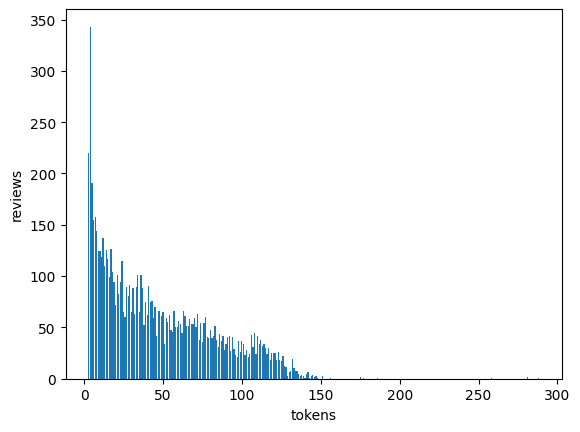

In [34]:
# Plota a distribui√ß√£o do tamanho das sequencias
#plt.hist(token_lens, bins=30)

plt.bar(np.unique(token_lens, return_counts=True)[0], np.unique(token_lens, return_counts=True)[1])
plt.xlabel('tokens')
plt.ylabel('reviews')
#plt.title('Distribui√ß√£o da qtde de tokens por review')
plt.show()

In [37]:
# Define o tamanho m√°ximo da sequ√™ncia de tokens baseado na distribui√ß√£o
MAX_LEN = 180

## Modelagem

Modelos pr√©-treinados na lingua portuguesa: 

* distilbert-base-multilingual-cased
* adalbertojunior/distilbert-portuguese-cased
* neuralmindbert-base-portuguese-cased

Separa√ß√£o em conjunto de treino e conjunto de teste com holdout

In [38]:

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleat√≥ria

# Separando entrada e sa√≠da
X = dataset['content']  # Texto do review limpo
y = dataset['sentiment'] # Sentimento 0(negativo)/2(negativo)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratifica√ß√£o

# Par√¢metros e parti√ß√µes da valida√ß√£o cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # valida√ß√£o cruzada com estratifica√ß√£o



### Treinamento e teste do modelo

In [39]:
# Verifica se a GPU est√° dispon√≠vel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_EPOCH = 10

# Fun√ß√£o para calcular m√©tricas
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

# Fun√ß√£o para treinar e avaliar o modelo
def train_and_evaluate(model_name):
    # Carrega o tokenizer e o modelo
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y_train)), ignore_mismatched_sizes=True)
    model.to(device)

    # Tokeniza os dados de treino e teste

    tokenized_train = tokenizer(
        X_train.tolist(),  # passa a lista de textos diretamente
        max_length=MAX_LEN,
        add_special_tokens=True,
        truncation=True,
        #padding=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    tokenized_test = tokenizer(
        X_test.tolist(),  # passa a lista de textos diretamente
        max_length=MAX_LEN,
        add_special_tokens=True,
        truncation=True,
        #padding=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Define argumentos de treinamento
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=NUM_EPOCH,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    # Define o Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=Dataset.from_dict({"input_ids": tokenized_train["input_ids"],
                                         "attention_mask": tokenized_train["attention_mask"],
                                         "labels": y_train}),
        eval_dataset=Dataset.from_dict({"input_ids": tokenized_test["input_ids"],
                                        "attention_mask": tokenized_test["attention_mask"],
                                        "labels": y_test}),
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Treina o modelo
    trainer.train()

    # Testa o modelo
    eval_results = trainer.evaluate()
    return  eval_results["eval_accuracy"], model, tokenizer

# Lista de modelos a serem testados
model_names = [
#    'neuralmind/bert-base-portuguese-cased',
    'distilbert/distilbert-base-multilingual-cased',
    'adalbertojunior/distilbert-portuguese-cased' #Equivalente ao bert-base-portuguese-cased por√©m menor
]

# Exibe a acuracia de cada modelo
results = {}
best_model = None
best_tokenizer = None
best_accuracy = 0
for model_name in model_names:
    accuracy, model, tokenizer = train_and_evaluate(model_name)
    results[model_name] = accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_tokenizer = tokenizer    
    print(f"Model: {model_name}, Accuracy: {accuracy}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: distilbert/distilbert-base-multilingual-cased, Accuracy: 0.891875


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at adalbertojunior/distilbert-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: adalbertojunior/distilbert-portuguese-cased, Accuracy: 0.903125


### Melhor modelo

In [40]:
# Melhor modelo
print(f"Best Model: {best_model.config._name_or_path}, Accuracy: {best_accuracy}")

Best Model: adalbertojunior/distilbert-portuguese-cased, Accuracy: 0.903125


### Simulando a aplica√ß√£o do modelo em dados n√£o vistos

In [62]:
# Novos dados - n√£o sabemos a classe!
data = [
    'Excelente app! A entrega foi super r√°pida, e a comida chegou quentinha. Adorei a variedade de restaurantes dispon√≠veis. Super recomendo para quem gosta de praticidade!', # 1 (Positivo)
    'O aplicativo √© super intuitivo e f√°cil de usar. Encontrei meus drinks favoritos em minutos, e o pagamento foi muito simples. Perfeito para uma noite em casa!', # 1 (Positivo)
    'O melhor app de delivery que j√° usei! Al√©m das op√ß√µes saud√°veis, a entrega √© sempre no hor√°rio e com um √≥timo atendimento. Nota 10!', # 1 (Positivo)
    'Aplicativo maravilhoso! A interface √© linda e super f√°cil de usar. Os cupons de desconto s√£o um b√¥nus que faz toda a diferen√ßa! ü§ëüíØ', # 1 (Positivo)
    'Gostei muito do app! A fun√ß√£o de rastreamento em tempo real da entrega √© excelente. Nunca mais fiquei na d√∫vida sobre o hor√°rio de chegada!', # 1 (Positivo)
    'A experi√™ncia foi frustrante. O aplicativo travou v√°rias vezes, e meu pedido chegou errado. Al√©m disso, o suporte ao cliente demorou muito para responder.', # 0 (Negativo)
    'Esperava mais do servi√ßo. A comida chegou fria e com apresenta√ß√£o ruim. O app tem um layout bonito, mas isso n√£o compensa a m√° qualidade da entrega.', # 0 (Negativo)
    'P√©ssimo! A entrega demorou quase duas horas e, quando finalmente chegou, a comida estava completamente gelada. N√£o recomendo. ', # 0 (Negativo)
    'Fiquei muito decepcionado. A interface do app √© confusa e dif√≠cil de navegar. Al√©m disso, tive problemas ao tentar finalizar o pagamento. N√£o usarei novamente.', # 0 (Negativo)
    'Horr√≠vel! Al√©m de demorar, o pedido veio errado. O suporte foi in√∫til e n√£o resolveu o problema. Nunca mais uso esse app! üëéüò°' # 0 (Negativo)
]

def predict(texts, tokenizer, model, device):
    inputs = tokenizer(texts, max_length=40, add_special_tokens=True, truncation=True, padding='max_length', return_attention_mask=True, return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model(**inputs)
    predictions = np.argmax(outputs.logits.detach().cpu().numpy(), axis=-1)
    return predictions

predictions = predict(data, best_tokenizer, best_model, 'cpu')
print(f"Predictions: {predictions}")


Predictions: [1 1 1 1 1 0 0 0 0 0]


### Salvando os arquivos

In [53]:
# Caminhos onde os arquivos ser√£o salvos
model_path = "../models/tf_sentiment_classifier/"

# Mover o modelo para a CPU antes de salvar
best_model.cpu()

# Salva o melhor modelo e tokenizer
best_model.save_pretrained(model_path)
best_tokenizer.save_pretrained(model_path)

('../models/tf_sentiment_classifier/tokenizer_config.json',
 '../models/tf_sentiment_classifier/special_tokens_map.json',
 '../models/tf_sentiment_classifier/vocab.txt',
 '../models/tf_sentiment_classifier/added_tokens.json',
 '../models/tf_sentiment_classifier/tokenizer.json')

### Teste do modelo salvo

In [66]:
# Caminhos onde os arquivos foram salvos
model_path = "../models/tf_sentiment_classifier/"

# Novos dados - n√£o sabemos a classe!
data = [ 
        'Muito bom!', # 1 (Positivo)
        'Droga.', # 0 (Negativo)
        'Muito ruim esse tempo.' # 0 (Negativo)
]

# Carrega o modelo e tokenizer do disco salvos para infer√™ncia

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

predictions = predict(data, tokenizer, model, 'cpu')
print(f"Predictions: {predictions}")

Predictions: [1 0 1]
